# Saving/Loading NDCube Objects from Zarr Files

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import sys
import os
import yaml
import glob

import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import distributed
from dask_jobqueue import PBSCluster
import astropy.units as u
import astropy.time
import sunpy.map
import ndcube
import zarr
import astropy.wcs
from astropy.visualization import ImageNormalize,SqrtStretch

import aiacube

%matplotlib inline

## Cluster Config

In [3]:
with open('../jobqueue-merope.yml','r') as f:
    config = yaml.load(f)['jobqueue']['pbs']

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [4]:
cluster = PBSCluster(**config)

In [2]:
cluster = distributed.LocalCluster()

In [3]:
client = distributed.Client(cluster)

In [20]:
cluster.scale(50)

## Load Level 2 Files

In [4]:
files = glob.glob(
    '/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl_2/aia_lev2_94_*.fits')

In [5]:
maps = client.map(sunpy.map.Map, files, pure=True)

In [6]:
cube = aiacube.AIACube.from_futures(maps, sort=True)

Changed DATE-OBS from '2010-09-29 13:00:02.120' to '2010-09-29T13:00:02.120''. [astropy.wcs.wcs]


In [20]:
#subcube = cube.crop_by_coords(
#    lower_corner=(0*u.s, 0*u.arcsec, 50*u.arcsec),
#    upper_corner=(12*u.h+12*u.s, 450*u.arcsec, 500*u.arcsec)
#)
subcube = cube.crop_by_coords(
    lower_corner=(0*u.s, 0*u.arcsec, 50*u.arcsec),
    upper_corner=(2*u.h, 450*u.arcsec, 500*u.arcsec),
)

In [21]:
subcube

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : -81.5  1.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  11.99999999999228  
NAXIS : 752  752  602
---------------------
Length of NDCube: [602. 752. 752.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [22]:
subcube.data

dask.array<getitem, shape=(602, 752, 752), dtype=float64, chunksize=(1, 752, 752), chunktype=numpy.ndarray>

In [10]:
subcube.wcs.to_header()

WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =               2048.5 / Pixel coordinate of reference point            
CRPIX2  =               2048.5 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =  0.00016666666666667 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00016666666666667 / [deg] Coordinate increment at reference point  
CDELT3  =      11.999999999992 / [s] Coordinate increment at reference point    
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CUNIT3  = 's'                  / Units of coordinate increment and value        
CTYPE1  = 'HPLN-TAN'           / Coordinate type codegnomonic projection        
CTYPE2  = 'HPLT-TAN'           / Coordinate type codegnomonic projection        
CTYPE3  = 'TIME'            

## Save to Zarr

This needs two steps:

1. Save the Dask array (easy)
2. Serialize the WCS to something JSON-friendly
  * Also would like to save metadata
  * And units (though this can be grabbed from metadata)

In [33]:
meta_list = [subcube.meta[i] for i in range(len(subcube.meta))]

In [35]:
meta_list[0] == subcube.meta[0]

True

In [81]:
wavelength = subcube.maps[0].wavelength
f'{wavelength.to(u.angstrom).value:.0f}'

'94'

In [62]:
def aiacube_to_zarr(cube, url, group):
    # Write array
    dask.array.to_zarr(cube.data, url, component=group)
    # Write WCS
    z = zarr.open(url, mode='a')
    z[group].attrs['wcs'] = dict(cube.wcs.to_header())
    # Write meta as list (to enforce order)
    z[group].attrs['meta'] = cube.meta

In [84]:
subcube.unit

Unit("ct / (pix s)")

In [83]:
isinstance(subcube.data, dask.array.Array)

True

In [70]:
def aiacube_from_zarr(url, group):
    data = dask.array.from_zarr(url, component=group)
    z = zarr.open(url, mode='r')
    wcs = z[group].attrs['wcs']
    for i in range(data.ndim):
        wcs[f'NAXIS{data.ndim - i}'] = data.shape[i]
    wcs = astropy.wcs.WCS(wcs)
    meta = z[group].attrs['meta']
    meta = {int(k):v for k,v in meta.items()}
    unit = meta[0]['bunit'] if 'bunit' in meta[0] else None
    return aiacube.AIACube(data, wcs, meta=meta, unit=unit)

In [23]:
z = zarr.open('/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl2_test.zarr', mode='w')
z.create_group('94')
z['94'].attrs['wcs'] = dict(subcube.wcs.to_header())
z['94'].attrs['meta'] = subcube.meta

In [26]:
aiacube_to_zarr(
    subcube,
    '/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl2_test.zarr',
    '94',
)

In [71]:
subcube_zarr = aiacube_from_zarr(
    '/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl2_test.zarr',
    '94',
)

In [60]:
subcube

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  11.99999999999228  
NAXIS : 4096  4096  602
---------------------
Length of NDCube: [ 602. 4096. 4096.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [42]:
subcube.data.shape

(602, 4096, 4096)

In [52]:
for i in range(subcube.data.ndim):
    print(f'NAXIS{subcube.data.ndim-i}', subcube.data.shape[i])

NAXIS3 602
NAXIS2 4096
NAXIS1 4096


In [57]:
subcube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  11.99999999999228  
NAXIS : 4096  4096  602

In [72]:
subcube_zarr

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  11.999999999992  
NAXIS : 4096  4096  602
---------------------
Length of NDCube: [ 602. 4096. 4096.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

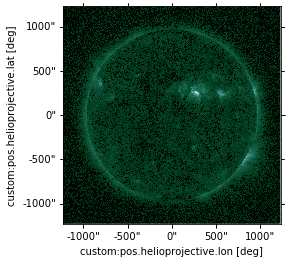

In [77]:
subcube_zarr[0,:,:].plot(
    cmap='sdoaia94',
    norm=ImageNormalize(vmin=0,vmax=5e1,stretch=SqrtStretch())
)

In [13]:
foo = zarr.open(
    '/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl2_test.zarr',
    mode='r',
)

In [14]:
foo['94'].attrs

KeyError: '94'

In [26]:
for k,v in subcube.wcs.to_header().items():
    print(k,v)

WCSAXES 3
CRPIX1 -81.5
CRPIX2 1.5
CRPIX3 1.0
CDELT1 0.00016666666666667
CDELT2 0.00016666666666667
CDELT3 11.999999999992
CUNIT1 deg
CUNIT2 deg
CUNIT3 s
CTYPE1 HPLN-TAN
CTYPE2 HPLT-TAN
CTYPE3 TIME
CRVAL1 0.0
CRVAL2 0.0
CRVAL3 0.0
LONPOLE 180.0
LATPOLE 0.0
DATE-OBS 2010-09-29T13:00:02.120
MJD-OBS 55468.541691204
MJD-OBS 55468.541691204


In [28]:
z = zarr.open('/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl2_test.zarr','a')
for k,v in subcube.wcs.to_header().items():
    z['94'].attrs[k] = v

In [29]:
data_zarr = dask.array.from_zarr(
    '/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl2_test.zarr',
    component='94',
)

In [30]:
data_zarr

dask.array<from-zarr, shape=(3601, 752, 752), dtype=float64, chunksize=(1, 752, 752), chunktype=numpy.ndarray>

In [32]:
z = zarr.open('/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl2_test.zarr', 'r')
#wcs_zarr = astropy.wcs.WCS({})

In [34]:
z['94'].attrs

dict_keys(['CDELT1', 'CDELT2', 'CDELT3', 'CRPIX1', 'CRPIX2', 'CRPIX3', 'CRVAL1', 'CRVAL2', 'CRVAL3', 'CTYPE1', 'CTYPE2', 'CTYPE3', 'CUNIT1', 'CUNIT2', 'CUNIT3', 'DATE-OBS', 'LATPOLE', 'LONPOLE', 'MJD-OBS', 'WCSAXES'])

In [80]:
subcube.maps[0].wavelength

<Quantity 94. Angstrom>

## Sandbox

In [24]:
subcube_rechunk =  subcube.rechunk(subcube.data.shape[:1] + (300,300))

In [25]:
subcube_rechunk.data

dask.array<rechunk-merge, shape=(602, 752, 752), dtype=float64, chunksize=(602, 300, 300), chunktype=numpy.ndarray>

In [26]:
subcube.to_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl2_test.zarr',)

In [27]:
subcube_zarr = aiacube.AIACube.from_zarr(
    '/nobackup/wtbarnes/time_lag/noaa_11109/aia_lvl2_test.zarr',
    94*u.angstrom,

)

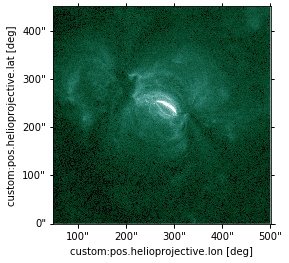

In [28]:
subcube_zarr[0,:,:].plot(
    cmap='sdoaia94',
    norm=ImageNormalize(vmin=0,vmax=5e1,stretch=SqrtStretch())
)